In [ ]:
## Try to extract a Don't Knowishness/Extremist Factor from the BES dataset

In [1]:
dataset_name = "W14_comb"
df_list = [
           "BES_Panel",
           "BES_reduced_with_na",
#            "BESnumeric"
#            "BES_reduced",
#            "BESnumeric"
          ]

In [2]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt, seaborn as sns
import pickle, os, gc, re

from IPython.display import display, display_html 

import Jupyter_module_loader
from utility import *
import gaussian_kde
# you should clone this git to a subdirectory called 'BES_analysis_code' (in some directory - I call it BES_analysis - doesn't matter though)
%matplotlib inline
encoding = "ISO-8859-1"

(BES_code_folder, BES_small_data_files, BES_data_folder,
 BES_output_folder, BES_file_manifest, BES_R_data_files) = setup_directories()


global BES_Panel, BES_numeric, BES_reduced, BES_reduced_with_na, BES_non_numeric
data_subfolder = BES_data_folder + dataset_name + os.sep

(manifest, dataset_filename, dataset_description, dataset_citation,
 dataset_start, dataset_stop, dataset_wave) = get_manifest(dataset_name, BES_file_manifest)

for df in df_list:
    if df=="BES_Panel":
        globals()[df]  = pd.read_msgpack(data_subfolder + dataset_filename.replace('.dta','.msgpack'))
    else:
        globals()[df]  = pd.read_msgpack(data_subfolder + df + '.msgpack' )
        globals()[df].replace(-1,np.nan,inplace=True)
  
(var_type, cat_dictionary, new_old_col_names, old_new_col_names) = get_small_files(data_subfolder, encoding)

max_wave, num_to_wave, num_to_weight, weights = get_weights(dataset_name,BES_Panel)

var_type (5692, 13)


In [54]:
BES_Panel_updated = pd.read_stata("E:\Downloads\BES2017_W14_Panel_v0.4.dta")

In [154]:
BES_Panel_updated.to_msgpack("E:\Downloads\BES2017_W14_Panel_v0.4"+".msgpack")

In [ ]:
#############################################
#############################################
# Don't Knowishness




In [3]:
%%time
null_perc = BES_reduced_with_na.isnull().mean(axis=1)

Wall time: 2.13 s


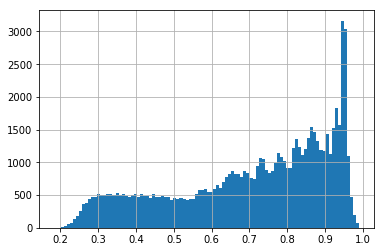

In [19]:
null_perc.hist(bins=100);

In [4]:
%%time
Weasel_answers = ["Don't know",
                  "Prefer not to say", "Prefer not to answer", "Refused", "Unknown",
                  "Neither", "Other", "I would/will not vote", "Will not vote",
                  "I would not vote", "It depends", "Other",
                  "Don't follow politics on twitter",
                  "Yes, other", "Haven't thought about it",
                  "There wasn't a local election in my area", "No, haven't received it",
                  "I don't know what was negotiated", "I never received a response",
                  "There are not local elections in my area", "Can't remember",
                  "Varies too much to say", "Will not state a choice",
                  "All leaders equally good", "They are not eligible to vote",
                  "There are not local elections in my area", "Both/neither",
                  "Did not vote","Can't remember",
                  "Not sure"]

# BES codes for NaN/other/misc/none of the above
Weasel_number_answers = [ "9999.0", "997.0", "222.0", "99.0", "0.0", "9999", "98.0" ]


dks = BES_Panel.applymap(lambda x: x in (Weasel_answers + Weasel_number_answers) if isinstance(x,str) else False)
dks_perc = dks.mean(axis=1)

Wall time: 3min 52s


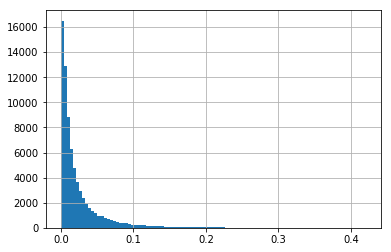

In [20]:
dks_perc.hist(bins=100);

In [5]:
dks_corr = BES_reduced_with_na.corrwith( dks_perc )
dks_corr.sort_values()

polAttentionW7__Pay a great deal of attention    -0.497479
polAttentionW8__Pay a great deal of attention    -0.489979
polAttentionW6__Pay a great deal of attention    -0.477177
polAttentionW4__Pay a great deal of attention    -0.474878
polAttentionW3__Pay a great deal of attention    -0.465438
polAttentionW2__Pay a great deal of attention    -0.447842
polAttentionW11__Pay a great deal of attention   -0.437203
electionInterestW4__Very interested              -0.433956
electionInterestW6__Very interested              -0.431522
electionInterestW5__Very interested              -0.430724
polAttentionW1__Pay a great deal of attention    -0.421134
polAttentionW10__Pay a great deal of attention   -0.418740
polAttentionW13__Pay a great deal of attention   -0.417758
efficacyUnderstandW6__Strongly agree             -0.412927
efficacyUnderstandW8__Strongly agree             -0.410544
efficacyUnderstandW4__Strongly agree             -0.408283
efficacyUnderstandW7__Strongly agree             -0.4010

In [6]:
from scipy import stats
# data = np.array([[0, 1, -1], [0, -1, 1], [0, 1, -1]])
# print 'np.corrcoef:', np.corrcoef(data)
# cor, pval = stats.spearmanr(data.T)
# print 'stats.spearmanr - cor:\n', cor
# print 'stats.spearmanr - pval\n', pval

In [7]:
%%time
BES_reduced_with_na["dks_perc"] = dks_perc

rho, pval = stats.spearmanr(BES_reduced_with_na.values, nan_policy='omit')

### this was actually *Waaaaaay* faster than the builtin pandas corr() function on the whole dataset - should save!
rho_all = pd.DataFrame(rho,columns = BES_reduced_with_na.columns, index = BES_reduced_with_na.columns)
pval_all = pd.DataFrame(pval,columns = BES_reduced_with_na.columns, index = BES_reduced_with_na.columns)
rho_all.to_msgpack(data_subfolder  + "rho_all"  + '.msgpack' )
pval_all.to_msgpack(data_subfolder + "pval_all" + '.msgpack' )

# can't use scipy pearson - doesn't handle nans!

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:3323: RuntimeWarning: invalid value encountered in sqrt
  t = rs * np.sqrt(((n-2)/((rs+1.0)*(1.0-rs))).clip(0))


Wall time: 4min 46s


In [14]:
rho.shape, pval.shape

((6865, 6865), (6865, 6865))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000001C52AEB8>]],
      dtype=object)

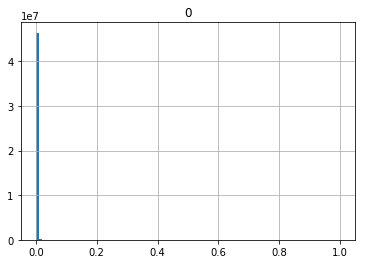

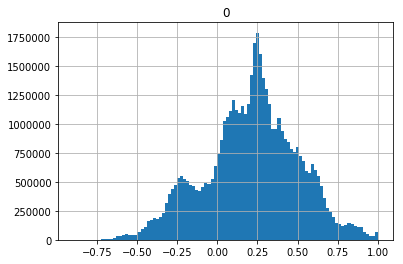

In [8]:
pd.DataFrame(pval.ravel()).hist(bins=100)
pd.DataFrame(rho.ravel()).hist(bins=100)

In [25]:
rho_all["dks_perc"].drop("dks_perc").sort_values()
# pd.Series(rho[rho.shape[0]-1],index = BES_reduced_with_na.columns).sort_values()

polAttentionW7__Pay a great deal of attention      -0.335439
profile_turnout_2015_Yes                           -0.329496
polAttentionW4__Pay a great deal of attention      -0.328927
polAttentionW8__Pay a great deal of attention      -0.319149
riskTakingW7__Very willing to take risks           -0.310255
polAttentionW6__Pay a great deal of attention      -0.309204
euRefInterestW7__Very interested                   -0.298122
profile_disability__No                             -0.290071
polAttentionW10__Pay a great deal of attention     -0.286193
efficacyUnderstandW4__Strongly agree               -0.285697
efficacyUnderstandW8__Strongly agree               -0.285267
efficacyUnderstandW7__Strongly agree               -0.284930
electionInterestW5__Very interested                -0.282513
polAttentionW11__Pay a great deal of attention     -0.282402
electionInterestW4__Very interested                -0.281557
electionInterestW6__Very interested                -0.280652
polAttentionW13__Pay a g

polAttentionW7__Pay a great deal of attention      -0.335439
profile_turnout_2015_Yes                           -0.329496
polAttentionW4__Pay a great deal of attention      -0.328927
polAttentionW8__Pay a great deal of attention      -0.319149
riskTakingW7__Very willing to take risks           -0.310255
polAttentionW6__Pay a great deal of attention      -0.309204
euRefInterestW7__Very interested                   -0.298122
profile_disability__No                             -0.290071
polAttentionW10__Pay a great deal of attention     -0.286193
efficacyUnderstandW4__Strongly agree               -0.285697
efficacyUnderstandW8__Strongly agree               -0.285267
efficacyUnderstandW7__Strongly agree               -0.284930
electionInterestW5__Very interested                -0.282513
polAttentionW11__Pay a great deal of attention     -0.282402
electionInterestW4__Very interested                -0.281557
electionInterestW6__Very interested                -0.280652
polAttentionW13__Pay a g

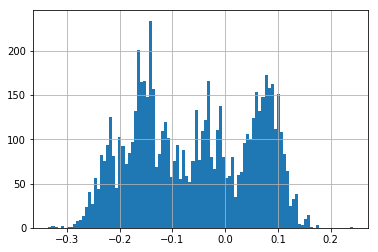

In [29]:
corr_series = rho_all["dks_perc"].drop("dks_perc").sort_values()
corr_series.hist(bins=100);

thresh = 0.005
# corr_series.quantile(thresh)
corr_series_highlights = corr_series[ np.logical_or(corr_series<corr_series.quantile(thresh),
                           corr_series>corr_series.quantile(1-thresh))]
corr_series_highlights

In [31]:
def get_stub(x):
    if "__" in x:
        x = x.split("__")[0]
    if "_" in x:
        x = x.split("_")[0]
    if re.match("(.+)(W\d)+",x):
        x = re.match("(.+?)(W\d)+",x).groups(0)[0]
    return x

np.unique([get_stub(x) for x in corr_series_highlights.index])


array(['age', 'blackEquality2', 'discussantClassName3',
       'discussantVoteName3', 'discussantturnoutName3',
       'eesEUIntegrationGreen', 'efficacyEU', 'efficacyEnjoyVote',
       'efficacyUnderstand', 'electionInterest', 'euRefInterest',
       'euRefTurnout', 'euRefpastVote', 'femaleEquality2', 'gayEquality2',
       'gender', 'immigGreen', 'infoSourcePaper', 'partySiteCon',
       'partySiteGreen', 'partySiteLD', 'partySiteLab', 'partySiteOth',
       'partySiteUKIP', 'polAttention', 'polKnowNetanyahu',
       'preschoolKidsInHouse', 'profile', 'redistGreen', 'registered',
       'riskTaking', 'sickElderlyInHouse', 'turnoutUKGeneral',
       'twitterInfo', 'twitterUse', 'visitPartySite'], dtype='<U22')

{'country_England': 'country',
 'country_Scotland': 'country',
 'country_Wales': 'country',
 'bestOnMIIW1_No party is best able to handle this issue': 'bestOnMIIW1',
 'bestOnMIIW1_Conservative': 'bestOnMIIW1',
 'bestOnMIIW1_Labour': 'bestOnMIIW1',
 'bestOnMIIW1_Liberal Democrat': 'bestOnMIIW1',
 'bestOnMIIW1_Scottish National Party (SNP)': 'bestOnMIIW1',
 'bestOnMIIW1_Plaid Cymru': 'bestOnMIIW1',
 'bestOnMIIW1_United Kingdom Independence Party (UKIP)': 'bestOnMIIW1',
 'bestOnMIIW1_Green Party': 'bestOnMIIW1',
 'bestOnMIIW1_British National Party (BNP)': 'bestOnMIIW1',
 'bestOnMIIW1_Other party': 'bestOnMIIW1',
 'countryOfBirth_England': 'countryOfBirth',
 'countryOfBirth_Scotland': 'countryOfBirth',
 'countryOfBirth_Wales': 'countryOfBirth',
 'countryOfBirth_Northern Ireland': 'countryOfBirth',
 'countryOfBirth_Republic of Ireland': 'countryOfBirth',
 'countryOfBirth_Other: Commonwealth member country': 'countryOfBirth',
 'countryOfBirth_Other: European Union member country': 'countryO

In [74]:
old_names = [x if x not in new_old_col_names.keys() else new_old_col_names[x] for x in corr_series_highlights.index]
list(set([ var_type.loc[x]["pruned"] for x in old_names]))

['euRefpastVote',
 'infoSourcePaper',
 'turnoutUKGeneral',
 'blackEquality',
 'visitPartySite',
 'registered',
 'discussantClassName',
 'polKnowNetanyahu',
 'polAttention',
 'partySiteGreen',
 'gayEquality',
 'efficacyEnjoyVote',
 'age',
 'twitterInfo',
 'eesEUIntegrationGreen',
 'partySiteLab',
 'riskTaking',
 'efficacyEU',
 'discussantVoteName',
 'profile_work_stat',
 'electionInterest',
 'partySiteCon',
 'euRefInterest',
 'redistGreen',
 'euRefTurnout',
 'immigGreen',
 'partySiteOth',
 'femaleEquality',
 'partySiteUKIP',
 'gender',
 'profile_turnout',
 'discussantturnoutName',
 'preschoolKidsInHouse',
 'efficacyUnderstand',
 'profile_disability',
 'twitterUse',
 'partySiteLD',
 'sickElderlyInHouse']

In [75]:
%%time
pattern = "dks_perc"
name = "dks_perc"
corr_type = "spearman"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
successReduceInequalityDKW4_Yes,0.46,0.00,31443
tryReduceInequalityDKW4_Yes,0.46,0.00,31443
achieveReduceImmigDKW11_Yes,0.44,0.00,30956
efficacyNotUnderstandW6__Strongly agree,0.39,0.00,29542
tryReduceImmigDKW4_Yes,0.38,0.00,31443
responsibleDebtDontKnowW4_Yes,0.38,0.00,31442
responsibleCrimeDontKnowW4_Yes,0.38,0.00,29305
responsibleCostLiveDontKnowW4_Yes,0.38,0.00,30573
responsibleEducationDontKnowW4_Yes,0.38,0.00,27557
responsibleNHSDontKnowW4_Yes,0.37,0.00,30200


In [80]:
%%time
pattern = "dks_perc"
name = "dks_perc"
corr_type = "pearson"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
responsibleDebtDontKnowW4_Yes,0.51,0.00,31442
tryReduceImmigDKW4_Yes,0.49,0.00,31443
responsibleEconDontKnowW4_Yes,0.48,0.00,30225
responsibleNHSDontKnowW4_Yes,0.48,0.00,30200
tryReduceInequalityDKW4_Yes,0.48,0.00,31443
responsibleCostLiveDontKnowW4_Yes,0.48,0.00,30573
responsibleEducationDontKnowW4_Yes,0.47,0.00,27557
responsibleImmigDontKnowW4_Yes,0.44,0.00,29775
achieveReduceImmigDKW11_Yes,0.43,0.00,30956
responsibleCrimeDontKnowW4_Yes,0.43,0.00,29305


Wall time: 1min 45s


In [ ]:
# BES_reduced_with_na["dks_perc"]

In [55]:
BES_Panel_updated["blackEquality2W14"].value_counts()/BES_Panel["blackEquality2W14"].value_counts().sum()

About right                   0.311343
Not gone far enough           0.256944
Gone too far                  0.151813
Don't know                    0.125193
Gone much too far             0.078897
Not gone nearly far enough    0.075810
Name: blackEquality2W14, dtype: float64

In [89]:
(BES_Panel["blackEquality2W14"].value_counts()/BES_Panel["blackEquality2W14"].value_counts().sum()).sort_index()

Not gone nearly far enough    0.075810
Not gone far enough           0.256944
About right                   0.311343
Gone too far                  0.151813
Gone much too far             0.078897
Don't know                    0.125193
Name: blackEquality2W14, dtype: float64

In [88]:
# search(BES_Panel,"blackEquality")
(BES_Panel["blackEqualityW6_W12"].value_counts()/BES_Panel["blackEqualityW6_W12"].value_counts().sum()).sort_index()

Not gone nearly far enough    0.059296
Not gone far enough           0.179993
About right                   0.365890
Gone too far                  0.189953
Gone much too far             0.116779
Don't know                    0.088089
Name: blackEqualityW6_W12, dtype: float64

In [87]:
(BES_Panel["blackEqualityW1W2W3W4W5"].value_counts()/BES_Panel["blackEqualityW1W2W3W4W5"].value_counts().sum()).sort_index()

Not gone nearly far enough    0.050181
Not gone far enough           0.147616
About right                   0.353164
Gone too far                  0.220044
Gone much too far             0.156255
Don't know                    0.072740
Name: blackEqualityW1W2W3W4W5, dtype: float64

In [84]:
(BES_Panel["femaleEqualityW1W2W3W4W5"].value_counts()/BES_Panel["femaleEqualityW1W2W3W4W5"].value_counts().sum()).sort_index()

Not gone nearly far enough    0.098586
Not gone far enough           0.303967
About right                   0.427392
Gone too far                  0.089803
Gone much too far             0.032374
Don't know                    0.047877
Name: femaleEqualityW1W2W3W4W5, dtype: float64

In [83]:
(BES_Panel["femaleEquality2W14"].value_counts()/BES_Panel["femaleEquality2W14"].value_counts().sum()).sort_index()

Not gone nearly far enough    0.090664
Not gone far enough           0.342014
About right                   0.333526
Gone too far                  0.101273
Gone much too far             0.035687
Don't know                    0.096836
Name: femaleEquality2W14, dtype: float64

In [86]:
(BES_Panel["gayEqualityW1W2W3W4W5"].value_counts()/BES_Panel["gayEqualityW1W2W3W4W5"].value_counts().sum()).sort_index()

Not gone nearly far enough    0.071756
Not gone far enough           0.185054
About right                   0.396122
Gone too far                  0.149080
Gone much too far             0.129497
Don't know                    0.068492
Name: gayEqualityW1W2W3W4W5, dtype: float64

In [82]:
(BES_Panel["gayEquality2W14"].value_counts()/BES_Panel["gayEquality2W14"].value_counts().sum()).sort_index()

Not gone nearly far enough    0.069059
Not gone far enough           0.243634
About right                   0.348573
Gone too far                  0.132523
Gone much too far             0.081211
Don't know                    0.125000
Name: gayEquality2W14, dtype: float64

In [47]:
BES_Panel["blackEquality2W14"].cat.categories


Index(['Not gone nearly far enough', 'Not gone far enough', 'About right',
       'Gone too far', 'Gone much too far', 'Don't know'],
      dtype='object')

In [41]:
mask = BES_reduced_with_na["blackEqualityW6_W12__Gone much too far"].isnull()
BES_reduced_with_na["blackEquality2W14__Gone much too far"][mask].value_counts()

2.0    1614
1.0    1332
3.0     787
4.0     409
0.0     393
Name: blackEquality2W14__Gone much too far, dtype: int64

In [ ]:
## after messaging Jonathan Mellon, he says this reflects new members of panel being more likely to say Don't Know
# Frustrating!

In [ ]:
# "OPTIONAL QUESTIONS" - answered by only some respondents - see a "DK" bump
# ... because people are being asked more questions? or because of the nature of the optional questions themselves?

# Are some questions targeted at people who said DK in past waves? E.g top ups like these?
# gayEquality2W14__Gone much too far                  0.173708
# blackEquality2W14__Gone much too far                0.174556
# femaleEquality2W14__Gone much too far               0.174776

In [56]:
BES_Panel["euRefpastVoteW14"].value_counts()

Stay/remain in the EU    2151
Leave the EU             1615
Don't know                 56
Name: euRefpastVoteW14, dtype: int64

In [57]:
BES_Panel["partySiteOthW4"].value_counts()

No            4344
Don't know     471
Yes            195
Name: partySiteOthW4, dtype: int64

In [ ]:
# positively correlated!

# patterns with DK variables 
# DontKnow, DK, _99, _dk, _111, _12



# fbInfo_2W12__Don't follow politics on facebook
# -> Don't follow politics on facebook
# decidedVoteW4_No, not decided yet
# strongestConnectionW11_None of the above

# blameLeave_12 -> None of these


# conNoneW4_Yes ???


# partyIdSqueezeW4_No - none
# profile_newspaperW13_None
# efficacyNoMatterW11__Strongly agree
# efficacyVoteEffortW4__Strongly agree
# efficacyTooMuchEffortW8__Strongly agree



# referendumContact_noneW3_Yes
# tryReduceInequalityNone


# al_scaleW13__Authoritarian
# al4W6__Strongly agree
# approveEUW2_Disapprove
# tuSupport/snpSupport mainly leave!
# strongLeaderW11__Strongly agree
# genTrustW7_Can't be too careful

# gender_Female	0.17


# mapdefined_9W3_Yes
# nationalUnemployment_a_1W3
# localUnemployment_a_1W3


# "One should disregard evidence that conflicts with one's established beliefs"

In [ ]:
# polAttentionW7__Pay a great deal of attention
# electionInterestW5__Very interested
# efficacyUnderstandW8__Strongly agree
# euRefInterestW7__Very interested
# efficacyEUW8__Strongly agree	
# discussPolDaysW4__7 days

# election turnout/interest, infosource (more time), election participation (internet petition), watch debates,
# political discussions, certainty about party pos on EU/immig/conservatives nat security

# partyMemberW6__Yes, I am a member of a party
# partyId
# trustMPsW8__A great deal of trust


# certaintyUKRemainW7__Very sure (sure about what would happen to the UK if it Remained)


# warmDenmarkW7__Very warm
# dutyToVote


# riskTakingW7__Very willing to take risks

# W13: Did anything happen during the election campaign that changed your view of any of the main political parties? -> Yes


# "People should revise their beliefs in response to new information or evidence"

In [111]:
df.loc[["aom1W7__Strongly agree","aom2W7__Strongly agree","aom3W7__Strongly agree",
        "aom4W7__Strongly agree","aom5W7__Strongly agree","aom6W7__Strongly agree",
        "aom7W7__Strongly agree"]]

,r,p,N,abs_r
aom1W7__Strongly agree,-0.14,0.0,7293,0.14
aom2W7__Strongly agree,-0.16,0.0,7412,0.16
aom3W7__Strongly agree,-0.17,0.0,7364,0.17
aom4W7__Strongly agree,0.10,0.0,7579,0.10
aom5W7__Strongly agree,0.11,0.0,7430,0.11
aom6W7__Strongly agree,0.11,0.0,7305,0.11
aom7W7__Strongly agree,0.18,0.0,7291,0.18


In [107]:
df.sort_values(by="r",ascending=True).head(100).tail(50)

,r,p,N,abs_r
ukipPriorities2_natsecW4_Yes,-0.20,0.0,7902,0.20
natSecurityGrnW13__Protect civil liberties,-0.20,0.0,18291,0.20
warmDenmarkW7__Very warm,-0.20,0.0,6948,0.20
participation_6W8_Yes,-0.20,0.0,6070,0.20
dutyToVote2W2__Strongly agree,-0.20,0.0,29679,0.20
pidInterestedOthersW7__Strongly agree,-0.20,0.0,6349,0.20
euSources_1W7_Yes,-0.20,0.0,24997,0.20
nonelecParticipation_1W6_Yes,-0.19,0.0,29175,0.19
pidPraiseGoodW11__Strongly agree,-0.19,0.0,5749,0.19
partyContactLab_5W11_Yes,-0.19,0.0,5596,0.19


In [103]:
BES_Panel["strongestConnectionW11"].value_counts()

None of the above                    2929
A town or city                       1328
A sports team                         843
Don't know                            530
A local church or religious group     501
A charity                             348
A musician or band                    333
A film/TV series                      304
A social club or community group      298
A School, college or university       258
A film star or famous celebrity        48
Name: strongestConnectionW11, dtype: int64

In [105]:
[x for x in BES_Panel.columns if "_12" in x]

['blameLeave_12W9', 'creditLeave_12W9']

In [ ]:
# positively correlated!

# patterns with DK variables 
# DontKnow, DK, _99, _dk, _111, _12

In [117]:
DK_vars = [x for x in BES_Panel.columns if re.search("DontKnow|DK|_99|_dk|_111|_12",x)]
BES_Panel[DK_vars].describe()

,responsibleDebtDontKnowW1,responsibleEconDontKnowW1,responsibleNHSDontKnowW1,responsibleEducationDontKnowW1,responsibleCostLiveDontKnowW1,responsibleImmigDontKnowW1,responsibleCrimeDontKnowW1,responsibleDebtDontKnowW2,responsibleEconDontKnowW2,responsibleNHSDontKnowW2,...,successReduceInequalityDKW12,achieveReduceImmigDKW12,discussantsSameAddress_99W12,partyContactDKW13,pContactEday_99W13,achieveReduceImmigDKW14,smallEmergency_99W14,moreParl_111W14,socialDes_dkW1W2W3W4W5,RPrivSchnew_dkW1_W4W7W9_W12W14
count,30342,29446,29117,26918,29727,28777,28529,30241,29244,28999,...,8820,34394,4922,14286,14112,31063,31063,7801.0,41692,70714
unique,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,3.0,2,2
top,No,No,No,No,No,No,No,No,No,No,...,No,No,No,No,No,No,No,0.0,No,No
freq,27602,26562,26170,23885,26774,25746,24155,27586,26503,26294,...,6432,26472,4801,14159,13418,21955,29285,6172.0,39403,69186


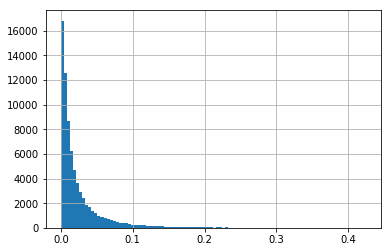

In [150]:
dks_aug = BES_Panel.applymap(lambda x: x in (Weasel_answers + Weasel_number_answers) if isinstance(x,str) else False)

dks_aug[DK_vars] = BES_Panel[DK_vars].applymap(lambda x: x in (Weasel_answers + ["Yes","North East"]))

dks_aug_perc = dks_aug.mean(axis=1)

dks_aug_perc.hist(bins=100);

In [151]:
BES_reduced_with_na["dks_aug_perc"] = dks_aug_perc

In [153]:
%%time
pattern = "dks_perc|dks_aug_perc|"+"|".join(DK_vars)
name = "dks_perc"
corr_type = "pearson"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
efficacyNotUnderstandW6__Strongly agree,0.35,0.00,29542
partyIdSqueezeW4_No - none,0.33,0.00,6178
mapdefined_9W3_Yes,0.3,0.00,15319
nationalUnemployment_a_1W3,0.26,0.00,15250
partyIdW9_No - none,0.25,0.00,28187
efficacyVoteEffortW4__Strongly agree,0.23,0.00,30710
efficacyNoMatterW11__Strongly agree,0.23,0.00,29982
fbInfo_2W12__Don't follow politics on facebook,0.22,0.00,22646
localUnemployment_a_1W3,0.21,0.00,15250
fbInfo_1W12__Don't follow politics on facebook,0.21,0.00,22646


Wall time: 1min 33s


In [156]:
var_type["type"].value_counts()

 1    4867
 3     377
-1     104
 5     100
 4      80
 2      51
 6      43
-3      31
-2      12
 0       9
 9       7
 8       7
-4       2
 7       1
-5       1
Name: type, dtype: int64

In [163]:
# we should drop the ones that are just two values!
ordinal_vars=  var_type[var_type["type"].apply(lambda x:x in [1,2,5])].index

In [172]:
ordinal_vars_in_df = intersection([x if x not in old_new_col_names.keys() else old_new_col_names[x] for x in ordinal_vars], BES_reduced_with_na.columns)


In [174]:
BES_reduced_with_na[ordinal_vars_in_df].min().value_counts()

0.0    3790
dtype: int64

In [190]:
num_cats = BES_reduced_with_na[ordinal_vars_in_df].apply(lambda x: len(np.unique(x.dropna()))  )
num_cats[num_cats>=3].index

Index(['turnoutUKGeneralW1__Very likely that I will vote',
       'turnoutUKGeneralW2__Very likely that I will vote',
       'turnoutUKGeneralW3__Very likely that I will vote',
       'turnoutUKGeneralW4__Very likely that I will vote',
       'turnoutUKGeneralW5__Very likely that I will vote',
       'turnoutUKGeneralW7__Very likely that I will vote',
       'turnoutUKGeneralW8__Very likely that I will vote',
       'turnoutUKGeneralW9__Very likely that I will vote',
       'turnoutUKGeneralW10__Very likely that I will vote',
       'turnoutUKGeneralW11__Very likely that I will vote',
       ...
       'lr_scaleW6__Right', 'al_scaleW6__Authoritarian',
       'lr_scaleW1W2W3W4W5__Right', 'al_scaleW1W2W3W4W5__Authoritarian',
       'lr_scaleW10W11W12__Right', 'al_scaleW10W11W12__Authoritarian',
       'lr_scaleW13__Right', 'al_scaleW13__Authoritarian',
       'lr_scaleW14__Right', 'al_scaleW14__Authoritarian'],
      dtype='object', length=2370)

In [191]:
ordinal_vars_in_df_three_or_more_cats = list(num_cats[num_cats>=3].index)

In [ ]:
top_values     = BES_reduced_with_na[ordinal_vars_in_df_three_or_more_cats].apply(lambda x: x==x.max())
bottom_values  = BES_reduced_with_na[ordinal_vars_in_df_three_or_more_cats].apply(lambda x: x==x.min())
# should these be relative to the number of options?

# e.g. choosing 10 on a 10pt scale more than 3 on a 3pt scale?

# Yes!

# meh - causes interpretation problems!
extreme_values = BES_reduced_with_na[ordinal_vars_in_df].apply(lambda x: (x==x.min()) | (x==x.max()) )


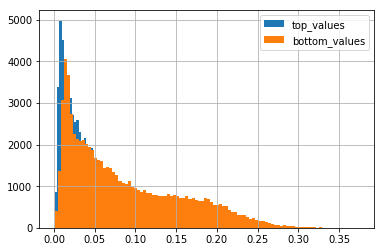

In [200]:
# extreme_values.mean(axis=1).hist(bins=100)
top_values.mean(axis=1).hist(bins=100, label="top_values"), bottom_values.mean(axis=1).hist(bins=100, label="bottom_values");
plt.legend();

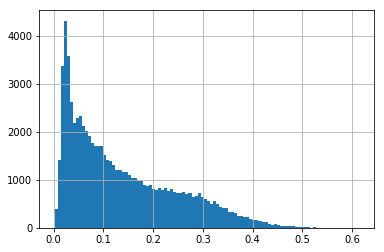

In [194]:
extreme_values.mean(axis=1).hist(bins=100);

In [212]:
original_ages = search(BES_reduced_with_na,"^age").index
original_ages

Index(['ageW1', 'ageW7', 'ageW8', 'ageW9', 'ageW11', 'ageW12', 'ageW13',
       'ageW14', 'age', 'ageGroup__66+', 'Age'],
      dtype='object')

In [213]:
## get standardised age
pan_dataset_ages = pd.read_msgpack(BES_small_data_files + "pan_dataset_ages"+".msgpack")

BES_reduced_with_na["pan_dataset_age_at_W1"] = pan_dataset_ages["Age_at_W1"]

In [223]:
pan_dataset_ages.columns

Index(['id', 'Age_at_W1', 'Age_at_W1_rounded', 'Age_at_W7', 'Age_at_W8',
       'Age_at_W9', 'Age_at_W11', 'Age_at_W12', 'Age_at_W13', 'Age_at_W14',
       'standardAgeGroup_at_W1', 'equalisedAgeGroup_at_W1',
       'equalLengthAgeGroup_at_W1'],
      dtype='object')

In [258]:
BES_reduced_with_na["extreme_values_perc"].corr(BES_reduced_with_na["pan_dataset_age_at_W1"])

0.36858842621250715

In [266]:
BES_reduced_with_na['ageW7'].corr(BES_reduced_with_na["pan_dataset_age_at_W1"])

0.9998578491124873

In [265]:
df.loc["pan_dataset_age_at_W1"]

r           -0.03
p            0.00
N        73703.00
abs_r        0.03
Name: pan_dataset_age_at_W1, dtype: float64

In [267]:
search(BES_reduced_with_na,"energyPriceCap")

energyPriceCapW12__Strongly agree    33112
dtype: int64

In [269]:
%%time
# BES_reduced_with_na["extreme_values_perc"] = extreme_values.mean(axis=1)
pattern = "energyPriceCap"
name = "energyPriceCapW12__Strongly agree"
corr_type = "pearson"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:3010: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den
C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:5256: RuntimeWarning: invalid value encountered in less
  x = np.where(x < 1.0, x, 1.0)  # if x > 1 then return 1.0


,r,p,N
renationaliseRailW11__Strongly agree,0.39,0.00,22034
cutsTooFarNationalW1__Gone much too far,0.37,0.00,13098
cutsTooFarNHSW1__Gone much too far,0.36,0.00,13031
lr3W6__Strongly agree,0.35,0.00,16289
lr4W6__Strongly agree,0.34,0.00,16394
polForTheRichW1__Strongly agree,0.33,0.00,13560
privatTooFarW6__Gone much too far,0.33,0.00,15367
tripleLockW12__Strongly agree,0.33,0.00,31693
cutsTooFarLocalW6__Gone much too far,0.33,0.00,15185
lr2W6__Strongly agree,0.33,0.00,16296


Wall time: 2min 10s


In [259]:
%%time
BES_reduced_with_na["extreme_values_perc"] = extreme_values.mean(axis=1)
pattern = "extreme_values_perc|bottom_values_perc|top_values_perc|"+"|".join(DK_vars)+"|"+"|".join(original_ages)
name = "extreme_values_perc"
corr_type = "pearson"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
polAttentionW4__Pay a great deal of attention,0.35,0.00,31230
efficacyUnderstandW4__Strongly agree,0.31,0.00,30536
profile_work_statW7_Retired,0.27,0.00,30030
electionInterestW4__Very interested,0.27,0.00,30618
turnoutUKGeneralW4__Very likely that I will vote,0.23,0.00,30846
"localTurnoutRetroW14_Yes, voted",0.23,0.00,14863
everUnionMemberW2_W12_W14_Yes,0.23,0.00,57084
workingStatusW6_W12_Retired,0.23,0.00,54416
profile_work_statW1_W10_Retired,0.22,0.00,9644
allSourceIncome_2W6_Yes,0.22,0.00,28471


Wall time: 3min 10s


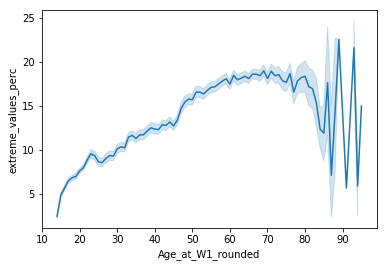

In [221]:
sns.lineplot(pan_dataset_ages["Age_at_W1_rounded"],BES_reduced_with_na["extreme_values_perc"]*100)

[17.5, 26.5, 34.5, 42.0, 50.0, 57.0, 63.5, 81.0]

C:\ProgramData\Anaconda3\envs\BES_analysis\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


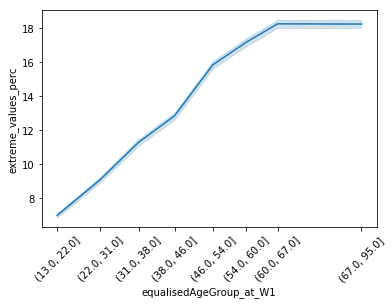

In [231]:
sns.lineplot(pan_dataset_ages["equalisedAgeGroup_at_W1"].apply(lambda x: x.mid),BES_reduced_with_na["extreme_values_perc"]*100)
plt.xticks([x.mid for x in pan_dataset_ages["equalisedAgeGroup_at_W1"].cat.categories],
           pan_dataset_ages["equalisedAgeGroup_at_W1"].cat.categories,
           rotation=45);

In [201]:
BES_reduced_with_na["top_values_perc"] = top_values.mean(axis=1)
BES_reduced_with_na["bottom_values_perc"] = bottom_values.mean(axis=1)


In [202]:
%%time
pattern = "extreme_values_perc|top_values_perc|bottom_values_perc|"+"|".join(DK_vars)
name = "top_values_perc"
corr_type = "pearson"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
bottom_values_perc,0.95,0.00,73703
ageW7,0.43,0.00,30895
Age,0.38,0.00,39142
polAttentionW4__Pay a great deal of attention,0.38,0.00,31230
efficacyUnderstandW4__Strongly agree,0.33,0.00,30536
ageGroup__66+,0.32,0.00,18108
electionInterestW4__Very interested,0.31,0.00,30618
efficacyEUW8__Strongly agree,0.28,0.00,32714
profile_work_statW7_Retired,0.27,0.00,30030
turnoutUKGeneralW4__Very likely that I will vote,0.26,0.00,30846


Wall time: 2min 22s


In [203]:
%%time
pattern = "extreme_values_perc|top_values_perc|bottom_values_perc|"+"|".join(DK_vars)
name = "bottom_values_perc"
corr_type = "pearson"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
bottom_values_perc,1,0.00,73703
ageW7,0.43,0.00,30895
Age,0.37,0.00,39142
polAttentionW4__Pay a great deal of attention,0.32,0.00,31230
ageGroup__66+,0.29,0.00,18108
efficacyUnderstandW4__Strongly agree,0.28,0.00,30536
profile_work_statW7_Retired,0.26,0.00,30030
electionInterestW4__Very interested,0.24,0.00,30618
"localTurnoutRetroW12_Yes, voted",0.22,0.00,20757
workingStatusW14_Retired,0.22,0.00,30269


Wall time: 1min 43s


In [264]:
%%time
GMTF = BES_Panel.applymap(lambda x: x == "Gone much too far" if isinstance(x,str) else False)
GMTF_perc = dks.mean(axis=1)
BES_reduced_with_na["GMTF_perc"] = GMTF_perc


pattern = "GMTF_perc|extreme_values_perc|top_values_perc|bottom_values_perc|"+"|".join(DK_vars)
name = "GMTF_perc"
corr_type = "pearson"
df,corr_type = make_corr_summary(BES_reduced_with_na, name, corr_type, pattern=pattern)
display_corr(df, name, corr_type, text_wrap_length=50)


,r,p,N
dks_aug_perc,1,0.00,73703
dks_perc,1,0.00,73703
efficacyNotUnderstandW6__Strongly agree,0.35,0.00,29542
partyIdSqueezeW4_No - none,0.33,0.00,6178
mapdefined_9W3_Yes,0.3,0.00,15319
nationalUnemployment_a_1W3,0.26,0.00,15250
partyIdW9_No - none,0.25,0.00,28187
efficacyNoMatterW11__Strongly agree,0.23,0.00,29982
efficacyVoteEffortW4__Strongly agree,0.23,0.00,30710
fbInfo_2W12__Don't follow politics on facebook,0.22,0.00,22646


Wall time: 5min 33s


In [234]:
################ Dredge-Regression

import shap
import xgboost as xgb
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import ElasticNet
from xgboost import XGBClassifier, XGBRegressor
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, explained_variance_score, r2_score

def shap_outputs(shap_values, train, target_var, output_subfolder, dependence_plots = False,
                 threshold = .1, min_features = 30, shap_problem= False):

    #################################
#     threshold = .1
#     min_features = 30
    global_shap_vals = np.abs(shap_values).mean(0)#[::-1]
    n_top_features = max( sum(global_shap_vals[np.argsort(global_shap_vals)]>=threshold),
                          min_features )
    # can't have more top features than there are features!
    n_top_features = min( train.shape[1], n_top_features)
#     if n_top_features <min_features:
#         n_top_features = min_features

    ##########################

    inds = np.argsort(global_shap_vals)[-n_top_features:]

    y_pos = np.arange(n_top_features)
    plt.figure(figsize=(16,10))
    plt.title(target_var);
    plt.barh(y_pos, global_shap_vals[inds], color="#1E88E5")
    plt.yticks(y_pos, train.columns[inds])
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['top'].set_visible(False)
    plt.xlabel("mean SHAP value magnitude (change in log odds)")
    plt.gcf().set_size_inches(6, 4.5)

    plt.savefig( output_subfolder + "mean_impact" + ".png", bbox_inches='tight' )

    plt.show()

    ####################
    
    fig = plt.figure()
    fig.suptitle(target_var);
    shap.summary_plot( shap_values, train, max_display=n_top_features, plot_type='dot' );
    if shap_problem:
        summary_text = "summary_plot(approx)"
    else:
        summary_text = "summary_plot"
    
    fig.savefig( output_subfolder + summary_text + ".png", bbox_inches='tight' )
    
        ##################
    if dependence_plots:
        count = 0
        for name in train.columns[inds[::-1]]:
            fig = plt.figure(figsize = (16,10))
            fig.suptitle(target_var);
            shap.dependence_plot(name, shap_values, train)
            fig.savefig(output_subfolder + "featureNo "+str(count) + " " + name.replace("/","_").replace(">","")[0:30] + ".png", bbox_inches='tight')
            count = count + 1

def get_wave_no(var):
    return int( re.search( 'W(\d+)($|_|\))', target_var ).groups()[0] )

def get_other_wave_pattern(wave_no, max_wave, num_to_wave):
    wave_seq = [num_to_wave[x] for x in range(1,max_wave+1) if (x>wave_no) or (x<wave_no) ]
    return "("+"|".join(wave_seq) +")" +"([^0-9-]|$)"

def remove_sublist(lst, sublist):
    # remove sublist from lst
    return list(set(lst) - set(sublist))

def get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                              sample_weights = None ):

    if len(target.value_counts())>10:
        stratify = pd.qcut(target,q=10,duplicates='drop').cat.codes
    else:
        target_index = target.value_counts().sort_index().index
        target_dict = {target_index[k]:k for k in range(0,len(target_index))}        
        stratify = target.apply(lambda x: target_dict[x])
    if sample_weights is not None:

        X_train, X_test, y_train, y_test = train_test_split( pd.concat( [train,sample_weights], axis=1 ),
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=stratify )

        eval_set = [(X_test, y_test)]

        sample_weight = X_train[weight_var].values
        sample_weight_eval_set = X_test[weight_var].values
        X_train.drop(weight_var, axis=1, inplace=True)
        X_test.drop(weight_var, axis=1, inplace=True)

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True, sample_weight = sample_weight)
        
    else:
        X_train, X_test, y_train, y_test = train_test_split( train,
                                                             target, test_size=test_size,
                                                             random_state=seed, stratify=stratify)

        eval_set = [(X_test, y_test)]

        alg.fit(X_train, y_train, eval_metric=eval_metric, 
                early_stopping_rounds = alg.get_params()['n_estimators']*early_stoppping_fraction,
                eval_set=eval_set, verbose=True )        
        

    # make predictions for test data
    predictions = alg.predict(X_test)

    # evaluate predictions
    MSE = mean_squared_error(y_test, predictions)
    MAE = mean_absolute_error(y_test, predictions)
    EV = explained_variance_score(y_test, predictions)
    R2 = r2_score(y_test, predictions)

    print("MSE: %.2f, MAE: %.2f, EV: %.2f, R2: %.2f" % (MSE, MAE, EV, R2) )
    alg.set_params(n_estimators=alg.best_iteration)

#     %%time
def run_xgboost():
    # for target_var,base_var in zip(var_list,base_list):
    treatment_subfolder = create_subdir(BES_output_folder,"xgb_regr"+Treatment)

    for target_var in var_list:
        if sample_wts:
            wave_no = get_wave_no( target_var )
            weight_var = num_to_weight[wave_no]    
            print( target_var, wave_no )

        target = create_target(target_var)
        mask   = target.notnull()
        if optional_mask & sample_wts:
            mask = mask&optional_mask_fn(wave_no)
        else:
            mask = mask&optional_mask_fn()
        target = target[mask]

        if sum(mask) < minimum_sample:
            continue

        train = create_train(drop_other_waves, mask)

        output_subfolder = create_subdir(treatment_subfolder,target_var)


        if sample_wts:
            sample_weights = weights[weight_var][mask]
            print("missing vals in sample weights: "+ str( sample_weights.isnull().sum() ) )
            sample_weights = sample_weights.fillna(sample_weights.median())
        else:
            sample_weights = None
    #         get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, sample_weights )
    #         # fit to full dataset at non-overfitting level
    #         alg.fit(train, target, verbose = True, sample_weight = sample_weights)        
    #     else:

        get_non_overfit_settings( train, target, alg, seed, early_stoppping_fraction, test_size, eval_metric, verbose = True,
                                  sample_weights=sample_weights )
        # fit to full dataset at non-overfitting level
        alg.fit(train, target, verbose = True, sample_weight = sample_weights)


    #################

        shap_values = shap.TreeExplainer(alg).shap_values(train);

        shap_problem = np.isnan(np.abs(shap_values).mean(0)).any()
        if shap_problem:
            print("hit problem!")
            shap_values = shap.TreeExplainer(alg).shap_values(train, approximate=True);

        shap_outputs(shap_values, train, target_var, output_subfolder, threshold = .1,
                     min_features = 30, shap_problem=shap_problem)


In [253]:
def setup_xgb_alg(n_estimators, treatment, var_stub, var_stub_list):

    Treatment = treatment
    var_stub = var_stub

    var_list = [var_stub]
    var_stub_list = var_stub_list
#     var_stub_list = [var_stub,"climateChange", "enviroGrowth","enviroProtection",
#                      "Bennett","grn","Grn","Lucas","handleMIIGrn","amalgamated",
#                      "Green","green"]
    
    alg = XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=.85,
           colsample_bytree=.9, gamma=0, learning_rate=0.01, max_delta_step=0,
           max_depth=3, min_child_weight=1, n_estimators=n_estimators,
           n_jobs=3, objective=objective, random_state=seed,
           reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
           subsample=.75
                       )    
    return (alg, Treatment, var_stub, var_list, var_stub_list)

optional_mask = False
sample_wts = False
drop_other_waves = False


objective = 'reg:linear'
eval_metric = 'rmse'

seed = 27
test_size = 0.33
minimum_sample = 100
early_stoppping_fraction = .1




# var_list

# default no wave
def optional_mask_fn(wave=[]):
    return 1


def create_train(drop_other_waves, mask=1):
    keep_list = BES_reduced_with_na.columns
#     keep_list = search(BES_reduced_with_na , "profile_house_tenure_|^Age$", case_sensitive=True).index

#     if drop_other_waves:
#         # drop variables from other waves
#         other_waves = get_other_wave_pattern(wave_no, max_wave, num_to_wave)
#         keep_list = [x for x in keep_list if not re.search( other_waves, x )]

    # drop key variables
#     keep_list = [x for x in keep_list if not any([var_stub in x for var_stub in var_stub_list])] 
    # explicit var_stub_list to exclude variables
    keep_list = [x for x in keep_list if x not in var_stub_list]
# profile_gross_household__£150,000 and over
# profile_gross_personal__£100,000 and over 
#     keep_list = ["profile_gross_household__£150,000 and over", "profile_gross_personal__£100,000 and over"]
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure|profile_gross|profile_house_tenure|profile_work_stat|mainSourceIncome|edlevel")].notnull().sum().index)
#     keep_list = list(BES_reduced_with_na[search(BES_reduced_with_na,"Amtb|profile_house_tenure_|profile_gross_household_"+\
#                            "|profile_gross_personal_|age")])
    return BES_reduced_with_na[keep_list][mask]


def create_target(target_var):

    return BES_reduced_with_na[target_var]#.apply(lambda x: min(x,89))




[0]	validation_0-rmse:0.37499
Will train until validation_0-rmse hasn't improved in 10.0 rounds.
[1]	validation_0-rmse:0.371305
[2]	validation_0-rmse:0.367656
[3]	validation_0-rmse:0.364051
[4]	validation_0-rmse:0.360477
[5]	validation_0-rmse:0.356939
[6]	validation_0-rmse:0.35344
[7]	validation_0-rmse:0.349974
[8]	validation_0-rmse:0.346542
[9]	validation_0-rmse:0.343145
[10]	validation_0-rmse:0.339782
[11]	validation_0-rmse:0.336454
[12]	validation_0-rmse:0.333159
[13]	validation_0-rmse:0.329898
[14]	validation_0-rmse:0.326672
[15]	validation_0-rmse:0.323477
[16]	validation_0-rmse:0.320313
[17]	validation_0-rmse:0.317186
[18]	validation_0-rmse:0.314086
[19]	validation_0-rmse:0.311017
[20]	validation_0-rmse:0.307978
[21]	validation_0-rmse:0.304972
[22]	validation_0-rmse:0.301995
[23]	validation_0-rmse:0.299048
[24]	validation_0-rmse:0.296134
[25]	validation_0-rmse:0.293247
[26]	validation_0-rmse:0.29039
[27]	validation_0-rmse:0.28756
[28]	validation_0-rmse:0.284763
[29]	validation_0-r

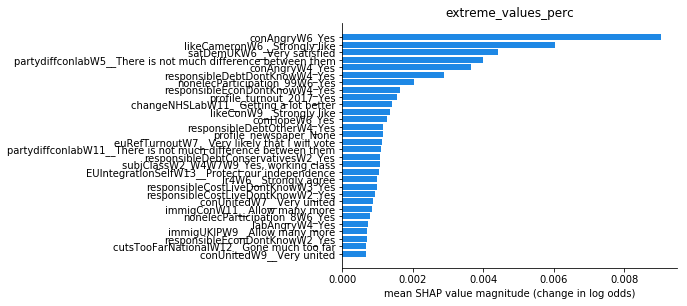

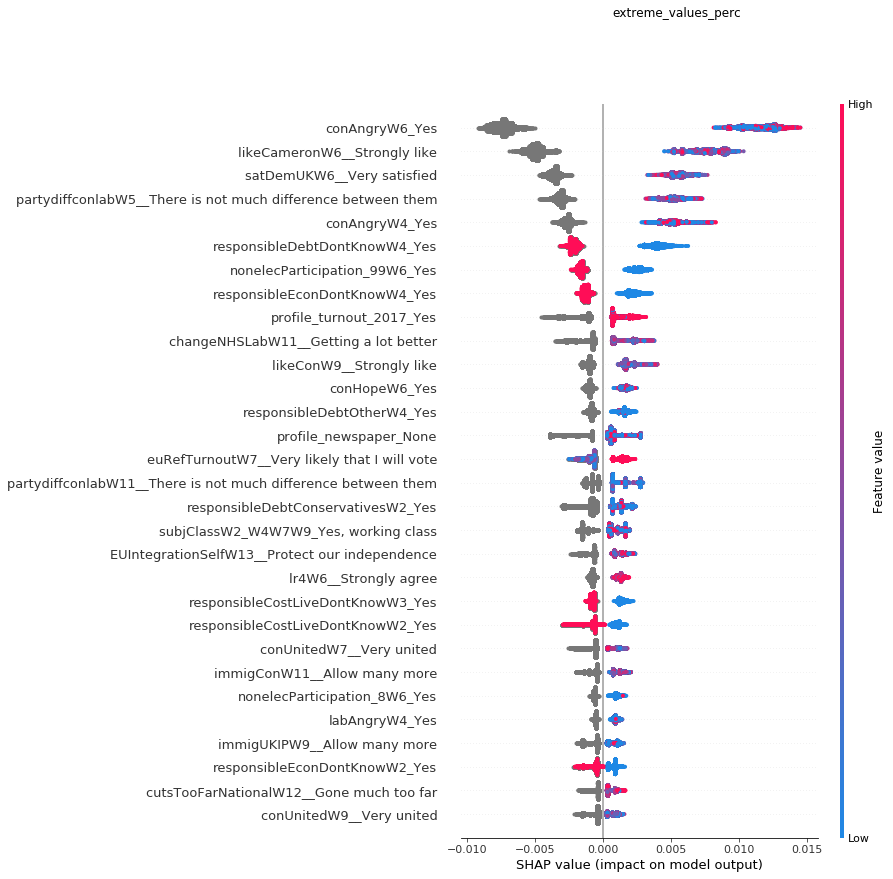

Wall time: 14min 8s


In [254]:
%%time
climate_dict = {"ExtremeValues":"extreme_values_perc"}
for climate_var in climate_dict.keys():

    (alg, Treatment, var_stub, var_list, var_stub_list) = setup_xgb_alg(n_estimators=100,
                                                                        treatment=climate_var,
                                                                        var_stub=climate_dict[climate_var],
                                                                        var_stub_list = ["extreme_values_perc","top_values_perc","bottom_values_perc"]+
                                                                                    DK_vars+list(original_ages))
    run_xgboost()

In [263]:
train["pan_dataset_age_at_W1"]

NameError: name 'train' is not defined